# PSPNet (Pyramid Scene Parsing Network)
https://arxiv.org/pdf/1612.01105

In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
DRIVE_ROOT = Path('/content/drive/MyDrive')

DATA_ROOT= Path('./data/')
MODEL_ROOT = DRIVE_ROOT / 'weights'

!mkdir -p {DATA_ROOT}
!mkdir -p {MODEL_ROOT}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install -q gdown
%pip install -q matplotlib
%pip install -q torchviz torchinfo
%pip install -q tqdm

In [3]:
from IPython.display import display

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary
from torchvision import datasets, models, ops, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

def get_device():
    '''Get device (CPU or GPU).'''
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import gdown

def download(fileid, filepath: Path):
    url = f'https://drive.google.com/uc?id={fileid}'
    if not filepath.exists():
        gdown.download(url, str(filepath), quiet=True)


# Download a pre-trained model by ADE20K.
download('12eN6SpnawYuQmD1k9VgVW3QSgPR6hICc', MODEL_ROOT/'pspnet50_ADE20K.pth')

## Dataset, Dataloader, Transformer
[PASCAL Visual Object Classes Challenge 2012 (VOC2012)](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html)

In [5]:
import PIL
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image: PIL.Image, label_image: PIL.Image):
        for t in self.transforms:
            image, label_image = t(image, label_image)
        return image, label_image


class Scale:
    def __init__(self, scale_range):
        self.scale_range = scale_range

    def __call__(self, image, label_image):
        w, h = image.size
        scale = np.random.uniform(self.scale_range[0], self.scale_range[1])

        scaled_w = int(w * scale)
        scaled_h = int(h * scale)

        image = TF.resize(image, (scaled_h, scaled_w), interpolation=InterpolationMode.BICUBIC)
        label_image = TF.resize(label_image, (scaled_h, scaled_w), interpolation=InterpolationMode.NEAREST)

        if scale > 1.0:
            top = np.random.randint(0, scaled_h - h + 1)
            left = np.random.randint(0, scaled_w - w + 1)

            image = TF.crop(image, top, left, h, w)
            label_image = TF.crop(label_image, top, left, h, w)

        else:
            # Add padding for shrink-operation.
            pad_h = h - scaled_h
            pad_w = w - scaled_w

            pad_top = np.random.randint(0, pad_h + 1)
            pad_left = np.random.randint(0, pad_w + 1)
            pad_bottom = pad_h - pad_top
            pad_right = pad_w - pad_left

            image = TF.pad(image, (pad_left, pad_top, pad_right, pad_bottom), fill=0)
            label_image = TF.pad(label_image, (pad_left, pad_top, pad_right, pad_bottom), fill=0)

        return image, label_image


class RandomRotation:
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, image, label_image):
        rotate_angle = np.random.uniform(-self.angle, self.angle)
        image = image.rotate(rotate_angle, PIL.Image.BILINEAR)
        label_image = label_image.rotate(rotate_angle, PIL.Image.NEAREST)
        return image, label_image


class RandomMirror:
    def __call__(self, image, label_image):
        if np.random.rand() > 0.5:
            image = TF.hflip(image)
            label_image = TF.hflip(label_image)
        return image, label_image


class Resize:
    def __init__(self, input_size):
        self.size = (input_size, input_size)

    def __call__(self, image, label_image):
        image = TF.resize(image, self.size, interpolation=transforms.InterpolationMode.BILINEAR)
        label_image = TF.resize(label_image, self.size, interpolation=transforms.InterpolationMode.NEAREST)
        return image, label_image


class Normalize_Tensor:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, label_image):
        image = TF.to_tensor(image)
        image = TF.normalize(image, self.mean, self.std)

        label_image = TF.pil_to_tensor(label_image).long().squeeze(0)
        label_image[label_image == 255] = 0
        return image, label_image

In [6]:
class ImageTransform:
    def __init__(self, input_size, color_mean, color_std):
        self.transform = {
            'train': Compose([
                Scale(scale_range=[0.5, 1.5]),
                RandomRotation(angle=10),
                RandomMirror(),
                Resize(input_size),
                Normalize_Tensor(color_mean, color_std),
            ]),
            'val': Compose([
                Resize(input_size),
                Normalize_Tensor(color_mean, color_std),
            ]),
        }

    def __call__(self, image: PIL.Image, label_image, phase):
        return self.transform[phase](image, label_image)

In [7]:
class VOCDataset(Dataset):
    def __init__(self, root, phase, download=True, transform=None):
        self.dataset = datasets.VOCSegmentation(root, year='2012', image_set=phase, download=download)
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.pull_item(idx)

    def pull_item(self, idx):
        image, label_image = self.dataset[idx]
        if self.transform:
            image, label_image = self.transform(image, label_image, self.phase)
        return image, label_image

    def get_original_image(self, idx):
        return self.dataset[idx][0]

    def get_original_label_image(self, idx):
        return self.dataset[idx][1]

In [8]:
INPUT_SIZE = 475
COLOR_MEAN = (0.485, 0.456, 0.406)
COLOR_STD = (0.229, 0.224, 0.225)
BATCH_SIZE = 8
download = True

train_dataset = VOCDataset(root=DATA_ROOT, phase='train', download=download,
                           transform=ImageTransform(INPUT_SIZE, COLOR_MEAN, COLOR_STD))
val_dataset = VOCDataset(root=DATA_ROOT, phase='val', download=download,
                         transform=ImageTransform(INPUT_SIZE, COLOR_MEAN, COLOR_STD))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

data_loaders = {'train': train_loader, 'val': val_loader}

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


## Network Models

### 1. Feature Map CNN

In [9]:
class ConvBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ConvBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        return x


class ConvBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ConvBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x


class FeatureMapCNN(nn.Module):
    def __init__(self):
        super(FeatureMapCNN, self).__init__()
        self.cbnr_1 = ConvBatchNormRelu(3, 64, kernel_size=3, stride=2, padding=1, dilation=1, bias=False)
        self.cbnr_2 = ConvBatchNormRelu(64, 64, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.cbnr_3 = ConvBatchNormRelu(64, 128, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        x = self.maxpool(x)
        return x

FeatureMapCNN()

FeatureMapCNN(
  (cbnr_1): ConvBatchNormRelu(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (cbnr_2): ConvBatchNormRelu(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (cbnr_3): ConvBatchNormRelu(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

### 2. Redidual Block

In [10]:
class BottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super(BottleNeckPSP, self).__init__()

        self.cbr_1 = ConvBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = ConvBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = ConvBatchNorm(
            mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        # Skip connection.
        self.cb_residual = ConvBatchNorm(
            in_channels, out_channels, kernel_size=1, stride=stride, padding=0, dilation=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)
        return self.relu(conv + residual)


class BottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super(BottleNeckIdentifyPSP, self).__init__()

        self.cbr_1 = ConvBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = ConvBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = ConvBatchNorm(
            mid_channels, in_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = x
        return self.relu(conv + residual)


class ResidualBlockPSP(nn.Sequential):
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super(ResidualBlockPSP, self).__init__()

        self.add_module(
            "block1",
            BottleNeckPSP(in_channels, mid_channels, out_channels, stride, dilation)
        )

        for i in range(n_blocks - 1):
            self.add_module(
                "block" + str(i+2),
                BottleNeckIdentifyPSP(out_channels, mid_channels, stride, dilation)
            )

ResidualBlockPSP(n_blocks=1, in_channels=8, mid_channels=4, out_channels=16, stride=1, dilation=1)

ResidualBlockPSP(
  (block1): BottleNeckPSP(
    (cbr_1): ConvBatchNormRelu(
      (conv): Conv2d(8, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbr_2): ConvBatchNormRelu(
      (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cb_3): ConvBatchNorm(
      (conv): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (cb_residual): ConvBatchNorm(
      (conv): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU(inplace=True)
 

### 3. Pyramid Pooling

In [11]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super(PyramidPooling, self).__init__()

        self.height = height
        self.width = width
        out_channels = in_channels // len(pool_sizes)

        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
        self.cbr_1 = ConvBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = ConvBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = ConvBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = ConvBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    def forward(self, x):
        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(
            out1, size=(self.height, self.width), mode="bilinear", align_corners=True)

        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(
            out2, size=(self.height, self.width), mode="bilinear", align_corners=True)

        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(
            out3, size=(self.height, self.width), mode="bilinear", align_corners=True)

        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(
            out4, size=(self.height, self.width), mode="bilinear", align_corners=True)

        output = torch.cat([x, out1, out2, out3, out4], dim=1)
        return output


PyramidPooling(in_channels=2048, pool_sizes=[6, 3, 2, 1], height=60, width=60)

PyramidPooling(
  (avpool_1): AdaptiveAvgPool2d(output_size=6)
  (cbr_1): ConvBatchNormRelu(
    (conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (avpool_2): AdaptiveAvgPool2d(output_size=3)
  (cbr_2): ConvBatchNormRelu(
    (conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (avpool_3): AdaptiveAvgPool2d(output_size=2)
  (cbr_3): ConvBatchNormRelu(
    (conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (avpool_4): AdaptiveAvgPool2d(output_size=1)
  (cbr_4): ConvBatchNormRelu(
    (conv): Conv2d(2048, 512, kernel_size=(1, 

### 4. Decoder

In [12]:
class DecodePSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super(DecodePSPFeature, self).__init__()

        self.height = height
        self.width = width

        self.cbr = ConvBatchNormRelu(
            in_channels=4096, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        x = F.interpolate(x, size=(self.height, self.width), mode="bilinear", align_corners=True)
        return x


DecodePSPFeature(height=60, width=60, n_classes=21)

DecodePSPFeature(
  (cbr): ConvBatchNormRelu(
    (conv): Conv2d(4096, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (dropout): Dropout2d(p=0.1, inplace=False)
  (classification): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
)

### 5. Auxiliary output

In [13]:
class AuxiliaryPSPlayers(nn.Module):
    def __init__(self, in_channels, height, width, n_classes):
        super(AuxiliaryPSPlayers, self).__init__()

        self.height = height
        self.width = width

        self.cbr = ConvBatchNormRelu(
            in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        x = F.interpolate(x, size=(self.height, self.width), mode="bilinear", align_corners=True)
        return x

AuxiliaryPSPlayers(in_channels=1024, height=60, width=60, n_classes=21)

AuxiliaryPSPlayers(
  (cbr): ConvBatchNormRelu(
    (conv): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (dropout): Dropout2d(p=0.1, inplace=False)
  (classification): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
)

In [14]:
class PSPNet(nn.Module):
    def __init__(self, n_classes, image_size=475, image_size_8=60, block_config=[3, 4, 6, 3]):
        super(PSPNet, self).__init__()

        self.feature_conv = FeatureMapCNN()
        self.feature_res_1 = ResidualBlockPSP(
            n_blocks=block_config[0], in_channels=128, mid_channels=64, out_channels=256, stride=1, dilation=1)
        self.feature_res_2 = ResidualBlockPSP(
            n_blocks=block_config[1], in_channels=256, mid_channels=128, out_channels=512, stride=2, dilation=1)
        self.feature_dilated_res_1 = ResidualBlockPSP(
            n_blocks=block_config[2], in_channels=512, mid_channels=256, out_channels=1024, stride=1, dilation=2)
        self.feature_dilated_res_2 = ResidualBlockPSP(
            n_blocks=block_config[3], in_channels=1024, mid_channels=512, out_channels=2048, stride=1, dilation=4)
        self.pyramid_pooling = PyramidPooling(
            in_channels=2048, pool_sizes=[6, 3, 2, 1], height=image_size_8, width=image_size_8)
        self.decode_feature = DecodePSPFeature(
            height=image_size, width=image_size, n_classes=n_classes)
        self.aux = AuxiliaryPSPlayers(
            in_channels=1024, height=image_size, width=image_size, n_classes=n_classes)

    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)

        output_aux = self.aux(x)

        x = self.feature_dilated_res_2(x)
        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)

        return (output, output_aux)

In [15]:
def weights_init(m):
    ''' Xavier initialization.'''
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)


def build_PSPNet(n_classes):
    model = PSPNet(n_classes=150)
    state_dict = torch.load(MODEL_ROOT/"pspnet50_ADE20K.pth", weights_only=False)
    model.load_state_dict(state_dict)

    # Replace classification layers to the one with N_CLASSES.
    model.decode_feature.classification = nn.Conv2d(
        in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    model.aux.classification = nn.Conv2d(
        in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    model.decode_feature.classification.apply(weights_init)
    model.aux.classification.apply(weights_init)
    return model


summary(build_PSPNet(21))

Layer (type:depth-idx)                   Param #
PSPNet                                   --
├─FeatureMapCNN: 1-1                     --
│    └─ConvBatchNormRelu: 2-1            --
│    │    └─Conv2d: 3-1                  1,728
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    └─ConvBatchNormRelu: 2-2            --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    │    └─ReLU: 3-6                    --
│    └─ConvBatchNormRelu: 2-3            --
│    │    └─Conv2d: 3-7                  73,728
│    │    └─BatchNorm2d: 3-8             256
│    │    └─ReLU: 3-9                    --
│    └─MaxPool2d: 2-4                    --
├─ResidualBlockPSP: 1-2                  --
│    └─BottleNeckPSP: 2-5                --
│    │    └─ConvBatchNormRelu: 3-10      8,320
│    │    └─ConvBatchNormRelu: 3-11      36,992
│    │    └─ConvBatchNorm: 3-12          16,896
│    │    └─ConvBatchNorm: 3-13          33,28

## Loss Function

In [16]:
class PSPLoss(nn.Module):
    def __init__(self):
        super(PSPLoss, self).__init__()

    def forward(self, outputs, outputs_aux, targets, aux_weight=0.4):
        loss = F.cross_entropy(outputs, targets, reduction='mean')
        loss_aux = F.cross_entropy(outputs_aux, targets, reduction='mean')
        return loss + aux_weight * loss_aux

## Train, Validate, Predict

In [17]:
def train(model, criterion, optimizer, data_loader, device, batch_multiplier=3):
    model.train()

    optimizer.zero_grad()
    n_batch = 0
    total_loss = 0
    with tqdm(data_loader, desc='Train', leave=False) as pbar:
        for images, label_images in pbar:
            images = images.to(device)
            label_images = label_images.to(device)

            outputs, outputs_aux = model(images)
            loss = criterion(outputs, outputs_aux, label_images.long()) / batch_multiplier
            loss.backward()

            if (n_batch + 1) % batch_multiplier == 0:
                optimizer.step()
                optimizer.zero_grad()

            n_batch += 1
            total_loss += loss.item() * batch_multiplier
            pbar.set_postfix({'train_loss': loss.item()})
    return total_loss / n_batch


@torch.no_grad()
def validate(model, criterion, data_loader, device):
    model.eval()

    n_batch = 0
    total_loss = 0
    with tqdm(data_loader, desc='Validate', leave=False) as pbar:
        for images, label_images in pbar:
            images = images.to(device)
            label_images = label_images.to(device)

            outputs, outputs_aux = model(images)
            loss = criterion(outputs, outputs_aux, label_images.long())

            n_batch += 1
            total_loss += loss.item()
            pbar.set_postfix({'val_loss': loss.item()})
    return total_loss / n_batch


def train_and_validate(num_epochs, model, criterion, optimizer, scheduler, data_loaders):
    device = get_device()
    model = model.to(device)
    torch.backends.cudnn.benchmark = True

    for epoch in range(num_epochs):
        train_loss = train(model, criterion, optimizer, data_loaders['train'], device)
        print(f'Epoch [{epoch+1}/{num_epochs}], train loss: {train_loss:.5f}')

        if ((epoch+1) % 10 == 0):
            # Validation.
            val_loss = validate(model, criterion, data_loaders['val'], device)
            print(f'val loss: {val_loss:.5f}')

        scheduler.step()

    # Save weights to a pth-file.
    pth_filepath = MODEL_ROOT / f'pspnet50_{num_epochs}.pth'
    print(f'Save the weights in {pth_filepath}')
    torch.save(model.state_dict(), pth_filepath)

In [18]:
def lambda_epoch(epoch):
    max_epoch = 60
    return math.pow((1-epoch/max_epoch), 0.9)


n_classes = 21
num_epochs = 60

model = build_PSPNet(n_classes)
criterion = PSPLoss()

optimizer = optim.SGD([
    {'params': model.feature_conv.parameters(), 'lr': 1e-3},
    {'params': model.feature_res_1.parameters(), 'lr': 1e-3},
    {'params': model.feature_res_2.parameters(), 'lr': 1e-3},
    {'params': model.feature_dilated_res_1.parameters(), 'lr': 1e-3},
    {'params': model.feature_dilated_res_2.parameters(), 'lr': 1e-3},
    {'params': model.pyramid_pooling.parameters(), 'lr': 1e-3},
    {'params': model.decode_feature.parameters(), 'lr': 1e-2},
    {'params': model.aux.parameters(), 'lr': 1e-2},
], momentum=0.9, weight_decay=0.0001)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)
train_and_validate(num_epochs, model, criterion, optimizer, scheduler, data_loaders)

Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [1/60], train loss: 1.37036


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [2/60], train loss: 0.73920


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [3/60], train loss: 0.63010


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [4/60], train loss: 0.56480


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [5/60], train loss: 0.51371


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [6/60], train loss: 0.48782


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [7/60], train loss: 0.45568


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [8/60], train loss: 0.43354


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [9/60], train loss: 0.41930


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [10/60], train loss: 0.41370


Validate:   0%|          | 0/182 [00:00<?, ?it/s]

val loss: 0.59596


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [11/60], train loss: 0.38134


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [12/60], train loss: 0.37847


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [13/60], train loss: 0.36539


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [14/60], train loss: 0.36538


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [15/60], train loss: 0.35178


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [16/60], train loss: 0.34828


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [17/60], train loss: 0.33338


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [18/60], train loss: 0.34173


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [19/60], train loss: 0.32576


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [20/60], train loss: 0.32366


Validate:   0%|          | 0/182 [00:00<?, ?it/s]

val loss: 0.56001


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [21/60], train loss: 0.32698


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [22/60], train loss: 0.32299


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [23/60], train loss: 0.29729


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [24/60], train loss: 0.30132


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [25/60], train loss: 0.30014


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [26/60], train loss: 0.29552


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [27/60], train loss: 0.29966


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [28/60], train loss: 0.29356


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [29/60], train loss: 0.27942


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [30/60], train loss: 0.28134


Validate:   0%|          | 0/182 [00:00<?, ?it/s]

val loss: 0.55454


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [31/60], train loss: 0.27269


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [32/60], train loss: 0.27187


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [33/60], train loss: 0.28476


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [34/60], train loss: 0.27779


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [35/60], train loss: 0.26849


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [36/60], train loss: 0.26708


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [37/60], train loss: 0.26452


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [38/60], train loss: 0.26326


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [39/60], train loss: 0.27694


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [40/60], train loss: 0.26381


Validate:   0%|          | 0/182 [00:00<?, ?it/s]

val loss: 0.56010


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [41/60], train loss: 0.26621


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [42/60], train loss: 0.26082


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [43/60], train loss: 0.25881


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [44/60], train loss: 0.25674


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [45/60], train loss: 0.25596


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [46/60], train loss: 0.25830


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [47/60], train loss: 0.26221


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [48/60], train loss: 0.26013


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [49/60], train loss: 0.25248


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [50/60], train loss: 0.25672


Validate:   0%|          | 0/182 [00:00<?, ?it/s]

val loss: 0.55118


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [51/60], train loss: 0.24896


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [52/60], train loss: 0.25503


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [53/60], train loss: 0.25697


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [54/60], train loss: 0.25078


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [55/60], train loss: 0.25700


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [56/60], train loss: 0.24546


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [57/60], train loss: 0.24954


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [58/60], train loss: 0.25544


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [59/60], train loss: 0.25470


Train:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch [60/60], train loss: 0.25496


Validate:   0%|          | 0/182 [00:00<?, ?it/s]

val loss: 0.54822
Save the weights in /content/drive/MyDrive/weights/pspnet50_60.pth


In [19]:
# n_classes = 21
# num_epochs = 60
model = PSPNet(n_classes=n_classes)

state_dict = torch.load(f"{MODEL_ROOT}/pspnet50_{num_epochs}.pth")
model.load_state_dict(state_dict)
model = model.to('cpu')

<ipython-input-19-65e6546ff438>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"{MODEL_ROOT}/pspnet50_{num_epochs}.pth")


In [20]:
class Segmentator:
    def __init__(self, transform_parameter, model, dummy_label_image):
        self.model = model
        self.transform = ImageTransform(**transform_parameter)
        self.dummy_label_image = dummy_label_image
        self.p_palette = dummy_label_image.getpalette()

    def show(self, input_image):
        _, axes = plt.subplots(1, 3, figsize=(10, 5))
        image = input_image.copy()

        image_width, image_height = image.size
        axes[0].imshow(image)
        axes[0].axis('off')

        # Inference.
        model.eval()
        image, _ = self.transform(input_image, self.dummy_label_image, 'val')
        x = image.unsqueeze(0)
        outputs, _ = model(x)
        preds = torch.argmax(outputs[0].detach(), dim=0)
        preds = preds.numpy().astype(np.uint8)

        # Generate the result from the model's output.
        label_image = PIL.Image.fromarray(preds, mode="P")
        label_image = label_image.resize((image_width, image_height), PIL.Image.NEAREST)
        label_image.putpalette(self.p_palette)
        axes[1].imshow(label_image)
        axes[1].axis('off')

        # Overlay the input image and the inferred result.
        alpha=150
        label_image = label_image.convert('RGB')
        trans_label_image = PIL.Image.new('RGBA', label_image.size, (0, 0, 0, 0))
        for x in range(image_width):
            for y in range(image_height):
                r, g, b = label_image.getpixel((x, y))

                if r == 0 and g == 0 and b == 0:
                    continue
                else:
                    trans_label_image.putpixel((x, y), (r, g, b, alpha))

        image = input_image.copy().convert('RGBA')
        result = PIL.Image.alpha_composite(image, trans_label_image)
        axes[2].imshow(result)
        axes[2].axis('off')
        plt.show()

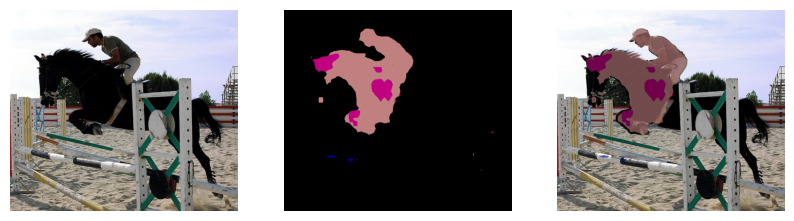

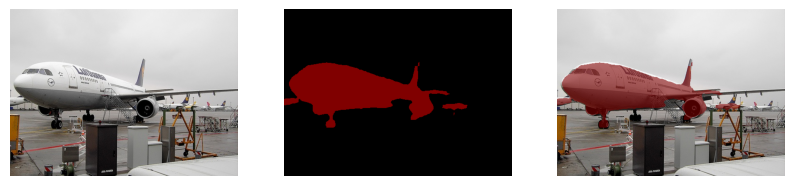

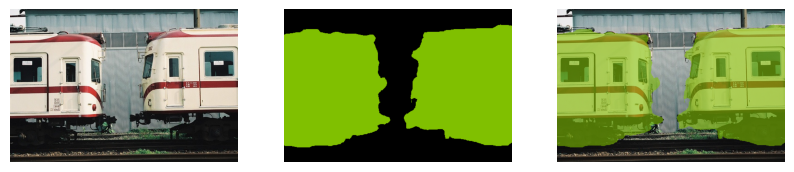

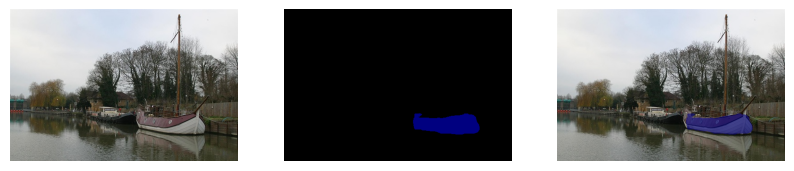

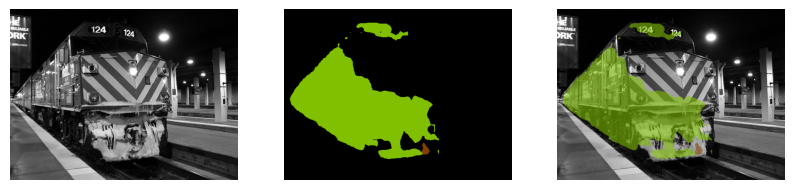

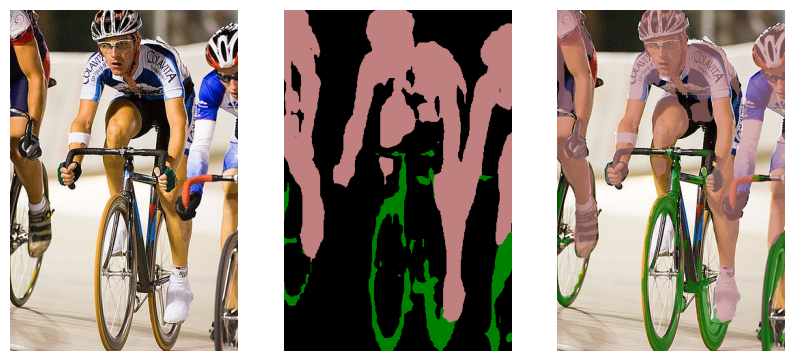

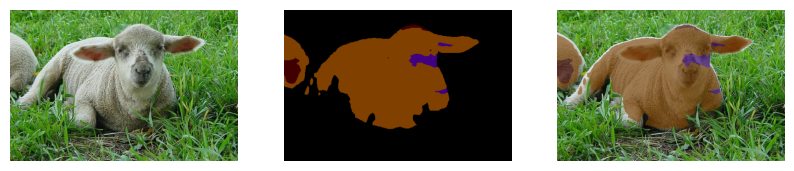

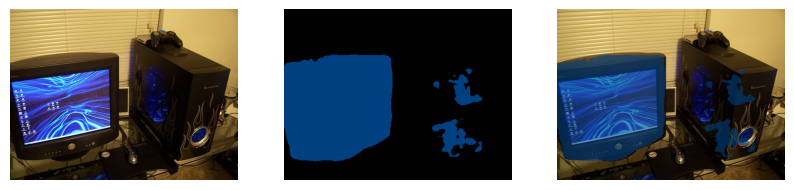

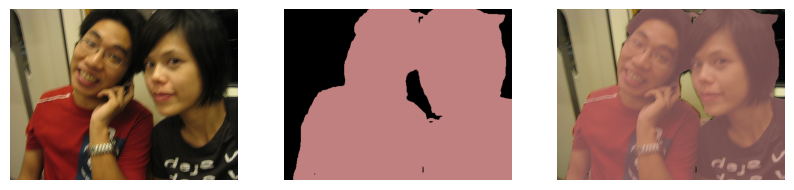

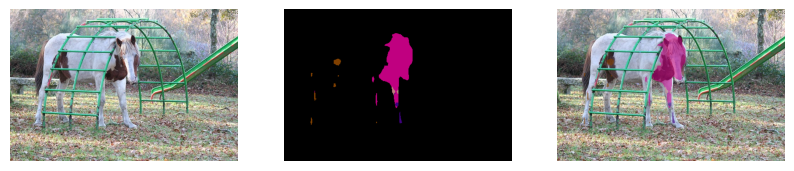

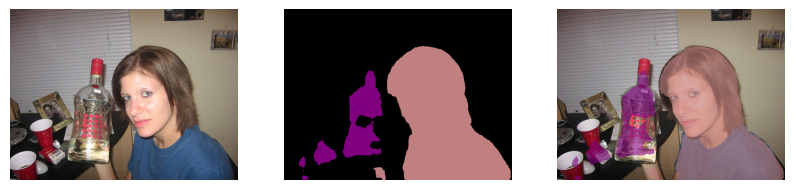

In [21]:
parameter = {
    'input_size': INPUT_SIZE,
    'color_mean': COLOR_MEAN,
    'color_std': COLOR_STD,
}

dummy_label_image = train_dataset.get_original_label_image(0)
segmentator = Segmentator(parameter, model, dummy_label_image)

image_file_path = DATA_ROOT/'VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg'
image = PIL.Image.open(image_file_path)
segmentator.show(image)

for i in range(10):
    image = val_dataset.get_original_image(i)
    segmentator.show(image)